---
layout: post
title: "Entropy와 Gini계수"
author: "Chanjun Kim"
categories: Data분석
tags: [DecisionTree, 의사결정나무, 불순도, Entropy와, Gini, 엔트로피, 지니계수, InformationGain, information]
image: 03_entropy_gini.png
---

## **목적**
- 지난번 포스팅에 ensemble 모델에 관하여 이야기하면서 약한 모형으로 의사결정나무를 많이 사용하는 것을 알 수 있었습니다. 이번에는 의사결정 나무를 만들기 위하여 사용되는 Entropy와 gini index에 대해서 알아보도록 하겠습니다.
<br/>
<br/>


### **트리 구축의 원칙**
![Oops](https://mblogthumb-phinf.pstatic.net/MjAxODEyMDlfMjYz/MDAxNTQ0MzY1Njc0OTY4.hFiUNsT9cpXJORVg3QGSLdx1F78bgZbOktHa3e7emnwg.P0iA6eeREGDfir58hS-s8ZMOak_P5-qHPPaR_bJePhwg.PNG.ehdrndd/image.png?type=w800)
> 출처 : https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=ehdrndd&logNo=221158124011
- 결정 트리를 구축할 때는 Occamm의 면도날처럼 데이터의 특성을 가장 잘 반영하는 간단한 가설을 먼저 채택하도록 되어있습니다. 어떻게 간단하고 합리적인 트리를 만들 수 있을 지 알아보겠습니다.
<br>
<br>

---

### **1. 결정 트리**
의사결정나무를 효율적으로 만들기 위해서는 변수의 기준에 따라 불순도/불확실성을 낮추는 방식으로 선택하여 만들게 됩니다.<br>
이에 불순도(Impurity) / 불확실성(Uncertainty)를 감소하는 것을 Information gain이라고 하며 이것을 최소화시키기 위하여 Gini Index와 Entropy라는 개념을 사용하게 되고 의사결정 나무의 종류에 따라 다르게 쓰입니다.<br>
sklearn에서 default로 쓰이는 건 gini계수이며 이는 CART(Classificatioin And Regression Tree)에 쓰입니다.<br>
ID3 그리고 이것을 개선한 C4.5, C5.0에서는 Entropy를 계산한다고 합니다. <br>
CART tree는 항상 2진 분류를 하는 방식으로 나타나며, Entropy 혹은 Entropy 기반으로 계산되는 Information gain으로 계산되며 다중 분리가 됩니다. <br>

- Gini계수와 Entropy 모두 높을수록 불순도가 높아져 분류를 하기 어렵습니다. <br>
![Oops](http://i.imgur.com/n3MVwHW.png)

|비 고|ID3|C4.5, C5|CART|
|:---:|:---:|:---:|:---:|
|평가지수|Entropy|Information gain|Gini Index(범주), 분산의 차이(수치)|
|분리방식|다지분리|다지분리(범주) 및 이진분리(수치)|항상2진 분리|
|비고|수치형 데이터 못 다룸|||

<br>
<br>
> 출처/참고자료 : https://ko.wikipedia.org/wiki/%EA%B2%B0%EC%A0%95_%ED%8A%B8%EB%A6%AC_%ED%95%99%EC%8A%B5%EB%B2%95 <br>
> 출처/참고자료 : https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=trashx&logNo=60099037740 <br>
> 출처/참고자료 : https://ratsgo.github.io/machine%20learning/2017/03/26/tree/

---

### **1. Gini Index**
일단 sklearn의 DecisionTreeClassifier의 default 값인 Gini 계수에 대해서 먼저 설명하겠습니다. <br> 

우선 Gini index의 공식입니다. <br>

- 영역의 데이터 비율을 제곱하여 더한 값을 1에서 빼주게 된다.<br>
![Oops](https://blog.kakaocdn.net/dn/uwQUP/btquI1QZpzV/zg919kn8JXk2n0bWovsYkk/img.png) <br>
<br>
- 두개 영역 이상이 되면 비율의 제곱의 비율을 곱하여 1에서 빼주게 된다.<br>
![Oops](https://blog.kakaocdn.net/dn/cfpPHK/btquKIXbRpq/5WF8UDRqrRAG5itVMx1oW0/img.png)
> 출처 : https://soobarkbar.tistory.com/17

<br>

- 최대값을 보게되면 1 - ( (1/2)^2 + (1/2)^2 ) = 0.5
- 최소값을 보게되면 1 - ( 1^2 + 0^2 ) = 0

In [83]:
import os
import sys

import math
import random
import numpy as np
import pandas as pd
import scipy

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

import matplotlib as mpl
from matplotlib import pyplot as plt
from plotnine import *

import graphviz
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

In [84]:
tennis = pd.read_csv("data/tennis.csv", index_col = "Day")
tennis

,Outlook,Temperature,Humidity,Wind,PlayTennis
Day,,,,,
D1,Sunny,Hot,High,Weak,No
D2,Sunny,Hot,High,Strong,No
D3,Overcast,Hot,High,Weak,Yes
D4,Rain,Mild,High,Weak,Yes
D5,Rain,Cool,Normal,Weak,Yes
D6,Rain,Cool,Normal,Strong,No
D7,Overcast,Cool,Normal,Strong,Yes
D8,Sunny,Mild,High,Weak,No
D9,Sunny,Cool,Normal,Weak,Yes


- 위와 같은 데이터가 있다고 할 때, 우리는 어떤 요인이 가장 확실한(불확실성이 적은) 변수일지 생각을 하고 트리를 만들어야합니다.

<br>
<br>

아무것도 나누지 않았을 때 gini계수를 구하는 함수를 만든 후 얼마인지 출력해보겠습니다

In [85]:
def get_unique_dict(df) :
    return {x : list(df[x].unique()) for x in ["Outlook", "Temperature", "Humidity", "Wind"]}

In [86]:
def get_gini(df, y_col) :
    Ys = df[y_col].value_counts()
    total_row = len(df)
    return 1 - np.sum([np.square(len(df[df[y_col] == y]) / total_row) for y in Ys.index])

In [87]:
def gini_split(df, y_col, col, feature) :
    r1 = len(df[df[col] == feature])
    Y1 = dict(df[df[col] == feature][y_col].value_counts())
    r2 = len(df[df[col] != feature])
    Y2 = dict(df[df[col] != feature][y_col].value_counts())
    
    ratio = r1 / (r1 + r2)
    gi1 = 1 - np.sum([np.square(len(df[(df[col] == feature) & (df[y_col] == x)]) / r1) for x, y in Y1.items()])
    gi2 = 1 - np.sum([np.square(len(df[(df[col] != feature) & (df[y_col] == x)]) / r2) for x, y in Y2.items()])
    
    return (ratio * gi1) + ((1-ratio) * gi2)

어떤 기준으로 나누었을 때 gini계수를 구하는 함수를 만들어 예시로 Outlook이 Sunny일 때 gini 계수를 구해보겠습니다.

In [88]:
get_gini(tennis, "PlayTennis")

0.4591836734693877

아무것도 나누지 않았을 때보다, Sunny로 나누었을 때 gini계수가 줄어드는 것을 볼 수 있습니다.<br>
이 때 이 차이값을 Information gain(정보획득)이라고 합니다. 그리고 정보획득량이 많은 쪽을 선택하여 트리의 구조를 만들기 시작합니다.

In [89]:
split_point = ["Outlook", "Sunny"]
print("{}, {} 기준 split 후 gini 계수 : {}".format(*split_point, gini_split(tennis, "PlayTennis", *split_point)))
print("information gain : {}".format(get_gini(tennis, "PlayTennis") - gini_split(tennis, "PlayTennis", *split_point)))

Outlook, Sunny 기준 split 후 gini 계수 : 0.3936507936507936
information gain : 0.06553287981859413


- 이제 모든 변수에 대해서 각각의 gini계수를 구하여 정보획득량이 많은, 즉 gini계수가 적은 변수를 선정하여 트리를 만들어갑니다.

In [90]:
y_col = "PlayTennis"
unique_dict = get_unique_dict(tennis)
unique_dict

{'Outlook': ['Sunny', 'Overcast', 'Rain'],
 'Temperature': ['Hot', 'Mild', 'Cool'],
 'Humidity': ['High', 'Normal'],
 'Wind': ['Weak', 'Strong']}

In [91]:
[f"col : {idx}, split_feature : {v} : gini_index = {gini_split(tennis, y_col, idx, v)}" for idx, val in unique_dict.items() for v in val]

['col : Outlook, split_feature : Sunny : gini_index = 0.3936507936507936',
 'col : Outlook, split_feature : Overcast : gini_index = 0.35714285714285715',
 'col : Outlook, split_feature : Rain : gini_index = 0.4571428571428571',
 'col : Temperature, split_feature : Hot : gini_index = 0.4428571428571429',
 'col : Temperature, split_feature : Mild : gini_index = 0.4583333333333333',
 'col : Temperature, split_feature : Cool : gini_index = 0.45',
 'col : Humidity, split_feature : High : gini_index = 0.3673469387755103',
 'col : Humidity, split_feature : Normal : gini_index = 0.3673469387755103',
 'col : Wind, split_feature : Weak : gini_index = 0.4285714285714286',
 'col : Wind, split_feature : Strong : gini_index = 0.42857142857142855']

In [92]:
gini_df = pd.DataFrame([[idx, v, gini_split(tennis, y_col, idx, v)] for idx, val in to_gini.items() for v in val], columns = ["cat1", "cat2", "gini"])

In [93]:
print(gini_df.iloc[gini_df["gini"].argmax()])
print(gini_df.iloc[gini_df["gini"].argmin()])

cat1    Temperature
cat2           Mild
gini       0.458333
Name: 4, dtype: object
cat1     Outlook
cat2    Overcast
gini    0.357143
Name: 1, dtype: object


---
임의로 x, y좌표를 생성하여 정보들이 얼마나 흩어져있는지 확인해보겠습니다.

In [94]:
def generate_xy(df, split_col = None, split_value = None) :
    if split_col == None :
        return df.assign(x = [random.random() for _ in range(len(df))], y = [random.random() for _ in range(len(df))])
    else :
        tmp_ = df[df[split_col] == split_value]
        tmp__ = df[df[split_col] != split_value]
        return pd.concat([tmp_.assign(x = [random.random() / 2 for _ in range(len(tmp_))], y = [random.random() for _ in range(len(tmp_))]),
                 tmp__.assign(x = [(random.random() / 2) + 0.5 for _ in range(len(tmp__))], y = [random.random() for _ in range(len(tmp__))])] )

- 아무런 기준을 두지 않았을 때는 정보를 구분할 수 있는 정보가 없습니다.

In [95]:
p = (
    ggplot(data = generate_xy(tennis), mapping = aes(x = "x", y = "y", color = y_col)) +
    geom_point() +
    theme_bw()
)
p.save("../assets/img/2021-06-01-Entropy/1.jpg")

C:\Users\Computer\Anaconda3\lib\site-packages\plotnine\ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
C:\Users\Computer\Anaconda3\lib\site-packages\plotnine\ggplot.py:707: UserWarning: Filename: ../assets/img/2021-06-01-Entropy/1.jpg
  warn('Filename: {}'.format(filename))


![Oops](../assets/img/2021-06-01-Entropy/1.jpg)

- Outlook이 Overcast로 나누었을 때, Yes 4개가 확실히 구분되는 것을 볼 수 있습니다.

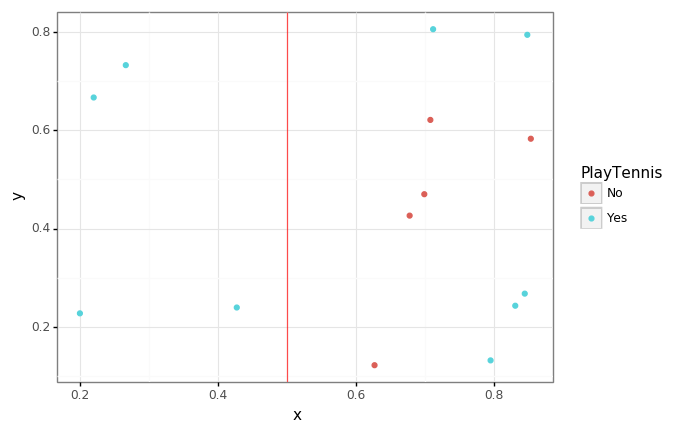

<ggplot: (154254005238)>

In [86]:
split_list = ["Outlook", "Overcast"]
(
    ggplot(data = generate_xy(tennis, *split_list), mapping = aes(x = "x", y = "y", color = y_col)) +
    geom_point() +
    geom_vline(xintercept = 0.5, color = "red", alpha = 0.7) +
    theme_bw() +
)

- 정보획득량이 가장 큰 Temperature가 Mild로 나누었을 때입니다.

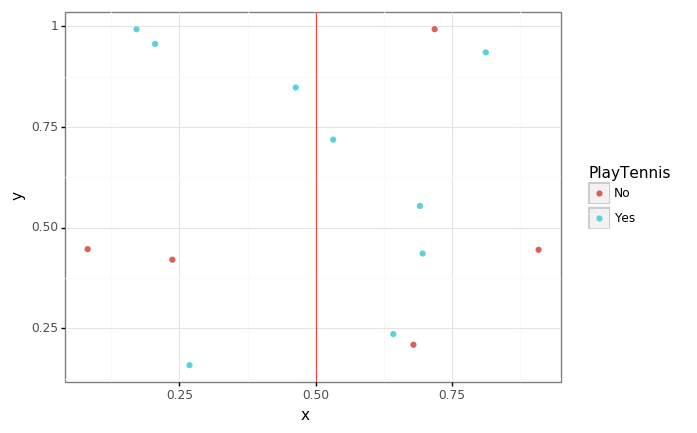

<ggplot: (-9223371882599089618)>

In [128]:
split_list = ["Temperature", "Mild"]
(
    ggplot(data = generate_xy(tennis, *split_list), mapping = aes(x = "x", y = "y", color = y_col)) +
    geom_point() +
    geom_vline(xintercept = 0.5, color = "red", alpha = 0.7) +
    theme_bw()
)

- Outlook이 Sunny, Rain으로 각각 나누었을 때입니다.

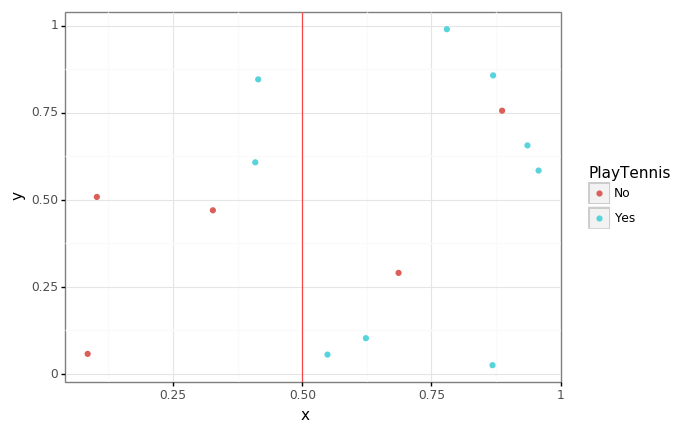

<ggplot: (-9223371882599508634)>

In [88]:
split_list = ["Outlook", "Sunny"]
(
    ggplot(data = generate_xy(tennis, *split_list), mapping = aes(x = "x", y = "y", color = y_col)) +
    geom_point() +
    geom_vline(xintercept = 0.5, color = "red", alpha = 0.7) +
    theme_bw()
)

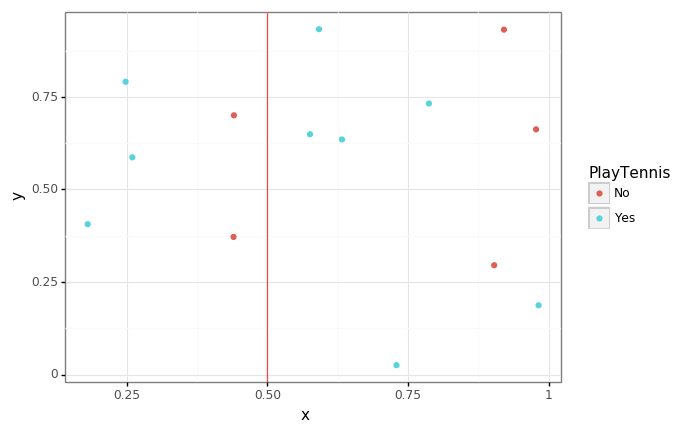

<ggplot: (154255759259)>

In [89]:
split_list = ["Outlook", "Rain"]
(
    ggplot(data = generate_xy(tennis, *split_list), mapping = aes(x = "x", y = "y", color = y_col)) +
    geom_point() +
    geom_vline(xintercept = 0.5, color = "red", alpha = 0.7) +
    theme_bw()
)

#### **실제 tree 모델과 비교하기 위하여 OneHotEncoding 후 트리모형을 돌려보도록 하겠습니다.

In [23]:
cols = ["Outlook", "Temperature", "Humidity", "Wind"]
oe = OneHotEncoder()

In [32]:
Xs = pd.get_dummies(tennis[cols])
Ys = tennis[y_col]

In [63]:
dt_gini = DecisionTreeClassifier(criterion="gini")
dt_gini.fit(Xs, Ys)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

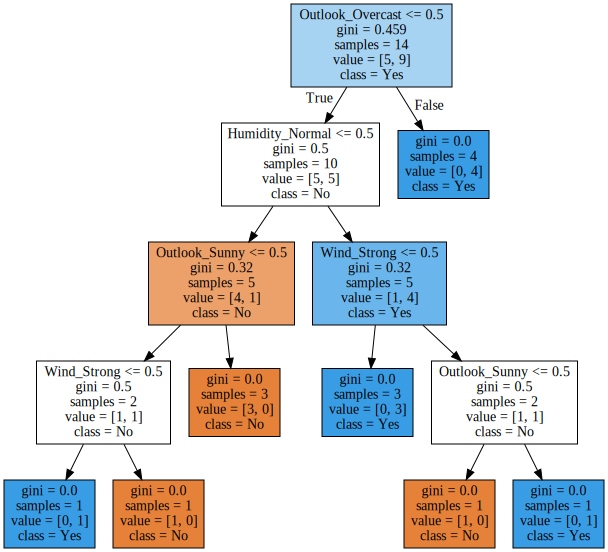

In [64]:
grp = tree.export_graphviz(dt_gini, out_file = None, feature_names=oh_df.columns,  
                   class_names=tennis[y_col].unique(),
                   filled=True)
graphviz.Source(grp, format = "png")

#### **실제로 이 순서가 맞는지 확인해보겠습니다**

In [36]:
get_gini(tennis, "PlayTennis")

0.4591836734693877

In [37]:
gini_df.iloc[gini_df["gini"].argmin()]

cat1     Outlook
cat2    Overcast
gini    0.357143
Name: 1, dtype: object

In [50]:
tennis_node1 = tennis[tennis["Outlook"] != "Overcast"]
[print(f"col : {idx}, split_feature : {v} : gini_index = {gini_split(tennis_node1, y_col, idx, v)}") for idx, val in get_unique_dict(tennis_node1).items() for v in val]
gini_df = pd.DataFrame([[idx, v, gini_split(tennis_node1, y_col, idx, v)] for idx, val in get_unique_dict(tennis_node1).items() for v in val], columns = ["cat1", "cat2", "gini"])
print("")
print("gini index : {}".format(get_gini(tennis_node1, y_col)))
print(gini_df.iloc[gini_df["gini"].argmin()])

col : Outlook, split_feature : Sunny : gini_index = 0.48
col : Outlook, split_feature : Rain : gini_index = 0.48
col : Temperature, split_feature : Hot : gini_index = 0.375
col : Temperature, split_feature : Mild : gini_index = 0.48
col : Temperature, split_feature : Cool : gini_index = 0.4761904761904763
col : Humidity, split_feature : High : gini_index = 0.31999999999999984
col : Humidity, split_feature : Normal : gini_index = 0.31999999999999984
col : Wind, split_feature : Weak : gini_index = 0.4166666666666667
col : Wind, split_feature : Strong : gini_index = 0.4166666666666667

gini index : 0.5
cat1    Humidity
cat2        High
gini        0.32
Name: 5, dtype: object


In [48]:
tennis_node2 = tennis[(tennis["Outlook"] != "Overcast") & (tennis["Humidity"] == "High")]
[print(f"col : {idx}, split_feature : {v} : gini_index = {gini_split(tennis_node2, y_col, idx, v)}") for idx, val in get_unique_dict(tennis_node2).items() for v in val]
gini_df = pd.DataFrame([[idx, v, gini_split(tennis_node2, y_col, idx, v)] for idx, val in get_unique_dict(tennis_node2).items() for v in val], columns = ["cat1", "cat2", "gini"])
print("")
print("gini index : {}".format(get_gini(tennis_node2, y_col)))
gini_df.iloc[gini_df["gini"].argmin()]

col : Outlook, split_feature : Sunny : gini_index = 0.2
col : Outlook, split_feature : Rain : gini_index = 0.2
col : Temperature, split_feature : Hot : gini_index = 0.26666666666666666
col : Temperature, split_feature : Mild : gini_index = 0.26666666666666666
col : Humidity, split_feature : High : gini_index = 0.31999999999999984
col : Wind, split_feature : Weak : gini_index = 0.26666666666666666
col : Wind, split_feature : Strong : gini_index = 0.26666666666666666

gini index : 0.31999999999999984


cat1    Outlook
cat2      Sunny
gini        0.2
Name: 0, dtype: object

#### - gini계수가 0이면 가장 끝쪽에 있는 terminal node가 됩니다.(데이터가 많으면 overfitting을 막기위하여 가지치기 컨셉이 활용됩니다)

In [52]:
tennis_ter1 = tennis[tennis["Outlook"] == "Overcast"]
[print(f"col : {idx}, split_feature : {v} : gini_index = {gini_split(tennis_ter1, y_col, idx, v)}") for idx, val in get_unique_dict(tennis_ter1).items() for v in val]
gini_df = pd.DataFrame([[idx, v, gini_split(tennis_ter1, y_col, idx, v)] for idx, val in get_unique_dict(tennis_ter1).items() for v in val], columns = ["cat1", "cat2", "gini"])
gini_df.iloc[gini_df["gini"].argmin()]

col : Outlook, split_feature : Overcast : gini_index = 0.0
col : Temperature, split_feature : Hot : gini_index = 0.0
col : Temperature, split_feature : Cool : gini_index = 0.0
col : Temperature, split_feature : Mild : gini_index = 0.0
col : Humidity, split_feature : High : gini_index = 0.0
col : Humidity, split_feature : Normal : gini_index = 0.0
col : Wind, split_feature : Weak : gini_index = 0.0
col : Wind, split_feature : Strong : gini_index = 0.0


cat1     Outlook
cat2    Overcast
gini           0
Name: 0, dtype: object

---

### **2. Entropy**
다음은 ID3, C4.5 등 트리에서 정보획득량을 측정하기 위해 쓰이는 Entropy입니다.<br> 

우선 Entropy의 공식입니다. <br>

- 영역의 데이터 비율을 제곱하여 더한 값을 1에서 빼주게 된다.<br>
![Oops](https://wikimedia.org/api/rest_v1/media/math/render/svg/57a7ee6d08213c28f3f633229d26d1f82ea71ba6)
<br>

In [154]:
max_entropy = (-1 * ((0.5*np.log2(0.5)) + (0.5*np.log2(0.5))))
min_entropy = (-1 * ((1*np.log2(1))))
print(f"Entropy의 최대값 : {max_entropy}")
print(f"Entropy의 최대값 : {min_entropy}")

Entropy의 최대값 : 1.0
Entropy의 최대값 : -0.0


In [155]:
tennis

,Outlook,Temperature,Humidity,Wind,PlayTennis
Day,,,,,
D1,Sunny,Hot,High,Weak,No
D2,Sunny,Hot,High,Strong,No
D3,Overcast,Hot,High,Weak,Yes
D4,Rain,Mild,High,Weak,Yes
D5,Rain,Cool,Normal,Weak,Yes
D6,Rain,Cool,Normal,Strong,No
D7,Overcast,Cool,Normal,Strong,Yes
D8,Sunny,Mild,High,Weak,No
D9,Sunny,Cool,Normal,Weak,Yes


In [53]:
def get_entropy(df, y_col) :
    Ys = df[y_col].value_counts()
    total_row = len(df)
    (-1 * ((0.5*np.log2(0.5)) + (0.5*np.log2(0.5))))
    return -1 *  np.sum([(len(df[df[y_col] == y]) / total_row) * np.log2(len(df[df[y_col] == y]) / total_row) for y in Ys.index])

In [54]:
get_entropy(tennis, y_col)

0.9402859586706311

In [55]:
def entropy_split(df, y_col, col, feature) :
    r1 = len(df[df[col] == feature])
    Y1 = dict(df[df[col] == feature][y_col].value_counts())
    r2 = len(df[df[col] != feature])
    Y2 = dict(df[df[col] != feature][y_col].value_counts())
    
    ratio = r1 / (r1 + r2)
    ent1 = np.sum([(len(df[(df[col] == feature) & (df[y_col] == x)]) / r1) * np.log2(len(df[(df[col] == feature) & (df[y_col] == x)]) / r1) for x, y in Y1.items()])
    ent2 = np.sum([(len(df[(df[col] != feature) & (df[y_col] == x)]) / r2) * np.log2(len(df[(df[col] != feature) & (df[y_col] == x)]) / r2) for x, y in Y2.items()])
    
    return -1 * ((ratio * ent1) + ((1-ratio) * ent2))

In [56]:
entropy_split(tennis, "PlayTennis", "Outlook", "Sunny")

0.8380423950607803

Entropy 역시 gini index와 똑같은 개념으로 아무것도 나누지 않았을 때보다, Sunny로 나누었을 때 줄어드는 것을 볼 수 있습니다.<br>
이 때 차이값(Information gain)을 이용하여 트리를 만들면 ID3, C4.5 등의 트리 구조를 만들게 됩니다.

In [57]:
[f"col : {idx}, split_feature : {v} : Entropy = {entropy_split(tennis, y_col, idx, v)}" for idx, val in get_unique_dict(tennis).items() for v in val]

['col : Outlook, split_feature : Sunny : Entropy = 0.8380423950607803',
 'col : Outlook, split_feature : Overcast : Entropy = 0.7142857142857143',
 'col : Outlook, split_feature : Rain : Entropy = 0.937101105625982',
 'col : Temperature, split_feature : Hot : Entropy = 0.9152077851647805',
 'col : Temperature, split_feature : Mild : Entropy = 0.9389462162661898',
 'col : Temperature, split_feature : Cool : Entropy = 0.9253298887416583',
 'col : Humidity, split_feature : High : Entropy = 0.7884504573082896',
 'col : Humidity, split_feature : Normal : Entropy = 0.7884504573082896',
 'col : Wind, split_feature : Weak : Entropy = 0.8921589282623617',
 'col : Wind, split_feature : Strong : Entropy = 0.8921589282623617']

In [76]:
entropy_df = pd.DataFrame([[idx, v, entropy_split(tennis, y_col, idx, v)] for idx, val in unique_dict.items() for v in val], columns = ["cat1", "cat2", "entropy"])

In [77]:
print(entropy_df.iloc[entropy_df["entropy"].argmin()])
print(entropy_df.iloc[gini_df["gini"].argmax()])

cat1        Outlook
cat2       Overcast
entropy    0.714286
Name: 1, dtype: object
cat1        Outlook
cat2          Sunny
entropy    0.838042
Name: 0, dtype: object


#### **실제 tree 모델과 비교하기 위하여 OneHotEncoding 후 트리모형을 돌려보도록 하겠습니다.**

In [65]:
dt_entropy = DecisionTreeClassifier(criterion="entropy")
dt_entropy.fit(Xs, Ys)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

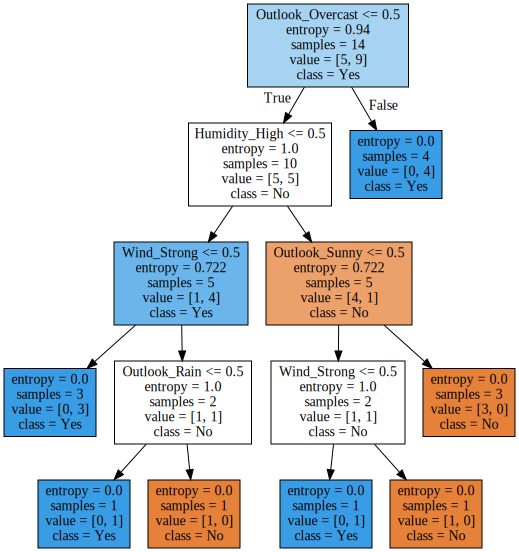

In [66]:
grp = tree.export_graphviz(dt_entropy, out_file = None, feature_names=oh_df.columns,  
                   class_names=tennis[y_col].unique(),
                   filled=True)
graphviz.Source(grp, format = "png")

#### **실제로 이 순서가 맞는지 확인해보겠습니다**

In [70]:
get_entropy(tennis, "PlayTennis")

0.9402859586706311

In [71]:
entropy_df.iloc[entropy_df["entropy"].argmin()]

cat1        Outlook
cat2       Overcast
entropy    0.714286
Name: 1, dtype: object

In [78]:
tennis_ter1 = tennis[tennis["Outlook"] == "Overcast"]
[print(f"col : {idx}, split_feature : {v} : entropy = {entropy_split(tennis_ter1, y_col, idx, v)}") for idx, val in get_unique_dict(tennis_ter1).items() for v in val]
entropy_df = pd.DataFrame([[idx, v, entropy_split(tennis, y_col, idx, v)] for idx, val in get_unique_dict(tennis_ter1).items() for v in val], columns = ["cat1", "cat2", "entropy"])
entropy_df.iloc[entropy_df["entropy"].argmin()]

col : Outlook, split_feature : Overcast : entropy = -0.0
col : Temperature, split_feature : Hot : entropy = -0.0
col : Temperature, split_feature : Cool : entropy = -0.0
col : Temperature, split_feature : Mild : entropy = -0.0
col : Humidity, split_feature : High : entropy = -0.0
col : Humidity, split_feature : Normal : entropy = -0.0
col : Wind, split_feature : Weak : entropy = -0.0
col : Wind, split_feature : Strong : entropy = -0.0


cat1        Outlook
cat2       Overcast
entropy    0.714286
Name: 0, dtype: object

In [79]:
tennis_ter1 = tennis[tennis["Outlook"] != "Overcast"]
[print(f"col : {idx}, split_feature : {v} : entropy = {entropy_split(tennis_ter1, y_col, idx, v)}") for idx, val in get_unique_dict(tennis_ter1).items() for v in val]
entropy_df = pd.DataFrame([[idx, v, entropy_split(tennis, y_col, idx, v)] for idx, val in get_unique_dict(tennis_ter1).items() for v in val], columns = ["cat1", "cat2", "entropy"])
entropy_df.iloc[entropy_df["entropy"].argmin()]

col : Outlook, split_feature : Sunny : entropy = 0.9709505944546686
col : Outlook, split_feature : Rain : entropy = 0.9709505944546686
col : Temperature, split_feature : Hot : entropy = 0.7635472023399721
col : Temperature, split_feature : Mild : entropy = 0.9709505944546686
col : Temperature, split_feature : Cool : entropy = 0.965148445440323
col : Humidity, split_feature : High : entropy = 0.7219280948873623
col : Humidity, split_feature : Normal : entropy = 0.7219280948873623
col : Wind, split_feature : Weak : entropy = 0.8754887502163469
col : Wind, split_feature : Strong : entropy = 0.8754887502163469


cat1       Humidity
cat2           High
entropy     0.78845
Name: 5, dtype: object

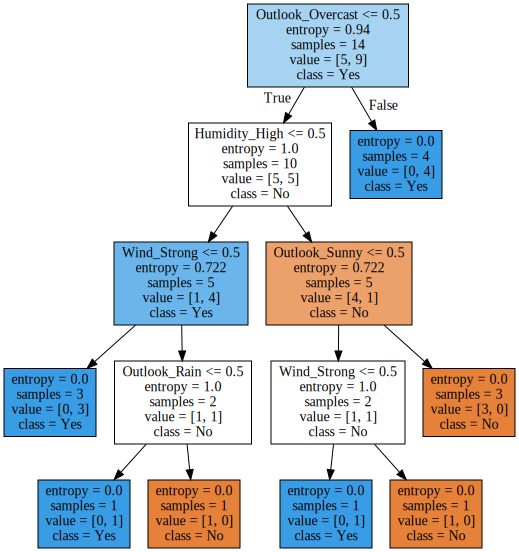

In [68]:
grp = tree.export_graphviz(dt_entropy, out_file = None, feature_names=oh_df.columns,  
                   class_names=tennis[y_col].unique(),
                   filled=True)
graphviz.Source(grp, format = "png")

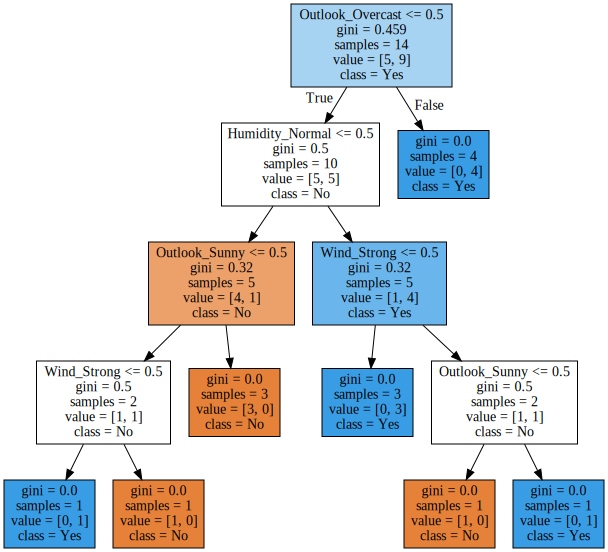

In [67]:
grp = tree.export_graphviz(dt_gini, out_file = None, feature_names=oh_df.columns,  
                   class_names=tennis[y_col].unique(),
                   filled=True)
graphviz.Source(grp, format = "png")

<br>
<br>

---
<br>

참고 자료 : [https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=ehdrndd&logNo=221158124011](https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=ehdrndd&logNo=221158124011)